In [1]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

import re

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

from datetime import datetime, timedelta, date
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.datasets import load_boston

import statsmodels.api as sm


Loading BokehJS ...

# Functions definitions

In [2]:
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return date(parts[2], parts[1], parts[0])

def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

def RegionError(region, data):
    d = data[data[region] == 1][["StoreID","Month","NumberOfSales","NumberOfPredictedSales"]].groupby(["StoreID","Month"]).agg("sum")
    res = abs(d["NumberOfSales"]-d["NumberOfPredictedSales"]).agg("sum")
    return res / d["NumberOfSales"].agg("sum")

def q(col, quant, f):
    t = sales[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    sales.loc[f(sales[col], t), col] = t
    
def qt(col, quant, f, data):
    t = data[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    data.loc[f(data[col], t), col] = t
    
def getFilterRegion(cluster, data):
    filterRegion = data[cluster[0]] == 1
    for region in cluster[1:]:
        filterRegion = ((filterRegion) | (data[region]==1))
    return filterRegion

def getColsMatching(data, oldCol):
    return [col for col in data.columns if re.match(r"("+oldCol+"_)(\d)", col)]

def dedummify(data, oldCol):
    return data[getColsMatching(data,oldCol)].idxmax(axis=1).apply(lambda x : x.split("_")[-1])

def Fit(cluster, train, test, model_simple_step2):
    
    #Get only the data for the required cluster in train and test set
    train_region_label= train.loc[getFilterRegion(cluster,train)]
    test_region_label= test.loc[getFilterRegion(cluster,test)]
    
    #removing the region columns in order to force the tree alghoritm to do not split for regions
    cols_not_for_step1 = ['Region_PopulationK','Region_AreaKM2','Region_GDP',*cluster]
    train_region_columns = train_region_label[cols_not_for_step1]
    train_region_label=train_region_label.drop(columns=cols_not_for_step1)

    test_region_columns = test_region_label[cols_not_for_step1]
    test_region_label=test_region_label.drop(columns=cols_not_for_step1)
    
    train_x_region_label_step1 = train_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    test_x_region_label_step1 = test_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    train_y_region_label_step1 = pd.DataFrame(data = train_region_label['NumberOfCustomers'])
    test_y_region_label_step1 = pd.DataFrame(data = test_region_label['NumberOfCustomers']) 
    
    #First model predicting NumberOfCustomers
    model_simple = RandomForestRegressor()
    model_simple = model_simple.fit(train_x_region_label_step1, train_y_region_label_step1)
    yp = model_simple.predict(test_x_region_label_step1) #yp=predicted customers del test
    
    test_region_label[cols_not_for_step1] = test_region_columns[cols_not_for_step1]
    train_region_label[cols_not_for_step1] = train_region_columns[cols_not_for_step1]
    
    # Prepare data for step2
    train_x_step2 = train.drop(columns=['NumberOfSales'])
    train_y_step2 = pd.DataFrame(data = train['NumberOfSales'])
    test_x_region_label_step2 = test_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    test_x_region_label_step2['NumberOfCustomers']= yp
    test_y_region_label_step2 = pd.DataFrame(data = test_region_label['NumberOfSales']) 
    
    cols_for_step2 = [*getColsMatching(train,"Month"), *getColsMatching(train,"Region"),'NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP', "StoreID"]
    train_x_step2 = train_x_step2[cols_for_step2]
    test_x_region_label_step2 = test_x_region_label_step2[cols_for_step2]
    
    #STEP2
    if model_simple_step2 == None:
        model_simple_step2 = RandomForestRegressor()
        model_simple_step2 = model_simple_step2.fit(train_x_step2, train_y_step2)
    yp2 = model_simple_step2.predict(test_x_region_label_step2) #yp2 = le sales predette alla fine
    
    # Restore Month columns after being dummified to ease the error estimation
    test_x_region_label_step2["Month"]=dedummify(test_x_region_label_step2, r"Month")
    # Prepare needed data
    check = pd.DataFrame(test_y_region_label_step2)
    check["NumberOfPredictedSales"] = yp2
    check["StoreID"] = test_x_region_label_step2[["StoreID"]]
    check['Month'] = test_x_region_label_step2['Month']
    check[cluster] = test_region_columns[cluster]
    
    errs = []
    for region_label in cluster:
        considered_region = (test_x_region_label_step2[region_label]==1).tolist()
        check2 = check[considered_region]
        check2[region_label]=1
        errs.append(RegionError(region_label, check2))
        print("Region " + (region_label.split("_")[-1]) + " : ", errs[-1])
    return model_simple_step2, errs

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like wstepwise_selectionith the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame( X.astype(float)[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame( X.astype(float)[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [3]:
#--------------------TEST-------------------

# DF TO EXCEL
from pandas import ExcelWriter


# Read input data

In [4]:
# Reading the data
sales = sales_string_date=pd.read_csv('train.csv')

# Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]

# Converting to category columns that are labels
for el in ["StoreID", "Region"]:
    sales[el] = sales[el].astype("category")

In [5]:


#-----------------------------TEST-----------------------------
#reading the test data for the submission
salesTest = pd.read_csv('test.csv')

# Removing tuples where stores are closed
salesTest = salesTest[salesTest['IsOpen'] == 1]

# Converting to category columns that are labels
for el in ["StoreID", "Region"]:
    salesTest[el] = salesTest[el].astype("category")


In [6]:
nulls = sales.isnull().sum()
sorted([(x,y) for (x,y) in zip(nulls.index, nulls) if y>0], key=lambda x: x[1], reverse=True)

[('Max_Gust_SpeedKm_h', 341404),
 ('Events', 103661),
 ('CloudCover', 34057),
 ('Max_VisibilityKm', 9258),
 ('Mean_VisibilityKm', 9258),
 ('Min_VisibilitykM', 9258)]

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.

Let's start with imputation of "Events"

In [7]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()

,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,103661.000000,103661.0,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,80397.000000,...,103661.000000,94779.000000,103661.000000,103661.000000,103661.000000,103661.000000,103661.000000,94779.000000,103661.000000,103661.000000
mean,0.001042,1.0,0.459179,8601.390619,314.641910,4893.577276,11435.271770,13711.770926,3467.389500,4.989340,...,11.545769,15.176421,11.082558,3.092774,40.196747,1015.171096,6.551538,10.586121,0.003920,134.812292
std,0.032261,0.0,0.498333,12222.596970,159.283348,2238.517426,8284.862826,2736.202628,2694.401824,2.233223,...,7.492758,6.648346,5.112519,6.093297,18.033663,7.151478,6.591203,6.138289,0.087722,103.812782
min,0.000000,1.0,0.000000,47.000000,0.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,...,-11.000000,2.000000,3.000000,-17.000000,10.000000,991.000000,-12.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.0,0.000000,1116.000000,215.000000,3375.000000,7215.000000,11849.000000,1293.000000,3.000000,...,6.000000,10.000000,6.000000,-2.000000,25.000000,1011.000000,1.000000,8.000000,0.000000,46.000000
50%,0.000000,1.0,0.000000,3614.000000,280.000000,4461.000000,9337.000000,13155.000000,1892.000000,5.000000,...,12.000000,13.000000,10.000000,3.000000,37.000000,1015.000000,7.000000,10.000000,0.000000,124.000000
75%,0.000000,1.0,1.000000,10593.000000,372.000000,5918.000000,15566.000000,15931.000000,5727.000000,7.000000,...,18.000000,19.000000,13.000000,8.000000,52.000000,1020.000000,12.000000,10.000000,0.000000,216.000000
max,1.000000,1.0,1.000000,85070.000000,2206.000000,26641.000000,32221.000000,23931.000000,8146.000000,8.000000,...,30.000000,31.000000,34.000000,18.000000,100.000000,1038.000000,23.000000,31.000000,4.060000,360.000000


In [8]:
sales['Events'].value_counts()

Rain                           171189
Fog                             56323
Fog-Rain                        41804
Rain-Thunderstorm               18116
Rain-Snow                       14576
Snow                            12541
Fog-Rain-Thunderstorm            6545
Fog-Snow                         2469
Fog-Rain-Snow                    2364
Thunderstorm                     1298
Rain-Hail                        1148
Rain-Snow-Hail                    513
Fog-Rain-Snow-Hail                231
Rain-Snow-Hail-Thunderstorm       193
Fog-Rain-Hail-Thunderstorm        178
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Rain-Snow-Thunderstorm            131
Rain-Hail-Thunderstorm             50
Name: Events, dtype: int64

By this, we discovered that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [9]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]

cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 

((103661, 36), (103661, 36), (23264, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [10]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [11]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [12]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [13]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     424700
Mean_VisibilityKm    424700
Min_VisibilitykM     424700
dtype: int64

In [14]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

In [15]:
#-----------------------------TEST-----------------------------

#IMPUTATION OF CLOUD_COVER

null_EventsT = salesTest['Events'].isnull()
null_CloudCoverT = salesTest['CloudCover'].isnull()
#cloudcover_missingT = salesTest[(null_EventsT)]
#event_missingT = salesTest[null_EventsT]

event_cc_missingT = salesTest[null_CloudCoverT & null_EventsT]

event_notmissing_cc_missingT = salesTest[null_CloudCoverT & ~null_EventsT]

#computing mean where CloudCover is not null
mean_CCT = salesTest["CloudCover"].mean()
event_notmissing_cc_missingT["CloudCover"] = event_notmissing_cc_missingT["CloudCover"].fillna(mean_CCT)
salesTest = pd.concat([salesTest[~null_CloudCoverT | null_EventsT], event_notmissing_cc_missingT])

CloudyButNotEventT = salesTest[null_EventsT]
#there are some tuples with no Events but with the attribute CloudCover

null_cloudCoverT = salesTest[salesTest['CloudCover'].isnull()]
mean_cloudCoverT = salesTest["CloudCover"].mean()
null_cloudCoverT["CloudCover"] = null_cloudCoverT["CloudCover"].fillna(mean_cloudCoverT)

salesTest = pd.concat([salesTest[~salesTest['CloudCover'].isnull()], null_cloudCoverT])

#IMPUTATION of  min,max,mean_VisibilityKm
null_visibilityT = salesTest[salesTest['Max_VisibilityKm'].isnull()]
#mean_vis_maxT = salesTest["Max_VisibilityKm"].mean()
#mean_vis_meanT = salesTest["Mean_VisibilityKm"].mean()
#mean_vis_minT = salesTest["Min_VisibilitykM"].mean()
#we use the mean of the training set
null_visibilityT["Max_VisibilityKm"] = null_visibilityT["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibilityT["Mean_VisibilityKm"] = null_visibilityT["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibilityT["Min_VisibilitykM"] = null_visibilityT["Min_VisibilitykM"].fillna(mean_vis_min)

salesTest = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])
#IMPUTATION of Events
salesTest=salesTest.replace(np.nan,'NotSpecified', regex=True)


#salesTest.isnull().sum()

Finally, we impute "Events".

In [16]:
sales=sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [17]:
sales.quantile(.99).sort_values(ascending=False).head(20)

NearestCompetitor             59199.0
Region_AreaKM2                32221.0
Region_GDP                    23931.0
NumberOfSales                 12460.0
Region_PopulationK             8146.0
StoreID                        1741.0
Max_Sea_Level_PressurehPa      1036.0
Mean_Sea_Level_PressurehPa     1033.0
Min_Sea_Level_PressurehPa      1031.0
NumberOfCustomers               886.0
WindDirDegrees                  353.0
Max_Humidity                    100.0
Mean_Humidity                    99.0
Min_Humidity                     93.0
Max_Wind_SpeedKm_h               50.0
Max_TemperatureC                 32.0
Max_VisibilityKm                 31.0
Mean_VisibilityKm                30.0
Min_VisibilitykM                 29.0
Mean_Wind_SpeedKm_h              29.0
Name: 0.99, dtype: float64

In [18]:
q("NearestCompetitor", .95, lambda x, y: x > y)
q("Precipitationmm", .95, lambda x, y: x > y)
q("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y)
q("Max_TemperatureC", .95, lambda x,y: x > y)
q("Max_TemperatureC", .03, lambda x,y: x < y)
q("Min_TemperatureC", .95, lambda x,y: x > y)
q("Min_TemperatureC", .03, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Humidity", .95, lambda x,y: x > y)
q("Mean_Humidity", .03, lambda x,y: x < y)
q("Min_VisibilitykM", .95, lambda x,y: x > y)
q("Min_Humidity", .03, lambda x,y: x < y)
q("Min_Humidity", .95, lambda x,y: x > y)
q("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Mean_TemperatureC", .03, lambda x,y: x < y)
q("Mean_TemperatureC", .95, lambda x,y: x > y)
q("Mean_VisibilityKm", .05, lambda x,y: x < y)
q("Mean_VisibilityKm", .95, lambda x,y: x > y)
#-----------------------TEST------------------------
qt("NearestCompetitor", .95, lambda x, y: x > y,salesTest)
qt("Precipitationmm", .95, lambda x, y: x > y,salesTest)
qt("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y,salesTest)
qt("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y,salesTest)
qt("Max_TemperatureC", .95, lambda x,y: x > y,salesTest)
qt("Max_TemperatureC", .03, lambda x,y: x < y,salesTest)
qt("Min_TemperatureC", .95, lambda x,y: x > y,salesTest)
qt("Min_TemperatureC", .03, lambda x,y: x < y,salesTest)
qt("Mean_Dew_PointC", .95, lambda x,y: x > y,salesTest)
qt("Mean_Dew_PointC", .05, lambda x,y: x < y,salesTest)
qt("Mean_Dew_PointC", .95, lambda x,y: x > y,salesTest)
qt("Mean_Dew_PointC", .05, lambda x,y: x < y,salesTest)
qt("Mean_Humidity", .95, lambda x,y: x > y,salesTest)
qt("Mean_Humidity", .03, lambda x,y: x < y,salesTest)
qt("Min_VisibilitykM", .95, lambda x,y: x > y,salesTest)
qt("Min_Humidity", .03, lambda x,y: x < y,salesTest)
qt("Min_Humidity", .95, lambda x,y: x > y,salesTest)
qt("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y,salesTest)
qt("Mean_TemperatureC", .03, lambda x,y: x < y,salesTest)
qt("Mean_TemperatureC", .95, lambda x,y: x > y,salesTest)
qt("Mean_VisibilityKm", .05, lambda x,y: x < y,salesTest)
qt("Mean_VisibilityKm", .95, lambda x,y: x > y,salesTest)

col NearestCompetitor at 0.95-th quantile => 31794.0
col Precipitationmm at 0.95-th quantile => 5.08
col Max_Wind_SpeedKm_h at 0.95-th quantile => 37.0
col Max_Wind_SpeedKm_h at 0.03-th quantile => 11.0
col Max_TemperatureC at 0.95-th quantile => 28.0
col Max_TemperatureC at 0.03-th quantile => 0.0
col Min_TemperatureC at 0.95-th quantile => 16.0
col Min_TemperatureC at 0.03-th quantile => -5.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Humidity at 0.95-th quantile => 94.0
col Mean_Humidity at 0.03-th quantile => 49.0
col Min_VisibilitykM at 0.95-th quantile => 11.0
col Min_Humidity at 0.03-th quantile => 19.0
col Min_Humidity at 0.95-th quantile => 84.0
col Mean_Wind_SpeedKm_h at 0.95-th quantile => 23.0
col Mean_TemperatureC at 0.03-th quantile => -2.0
col Mean_TemperatureC at 0.95-th quantile => 21.0
col Mean_VisibilityKm at 0.

# Normalization of Numerical Variables

Text(0.5,1,'')

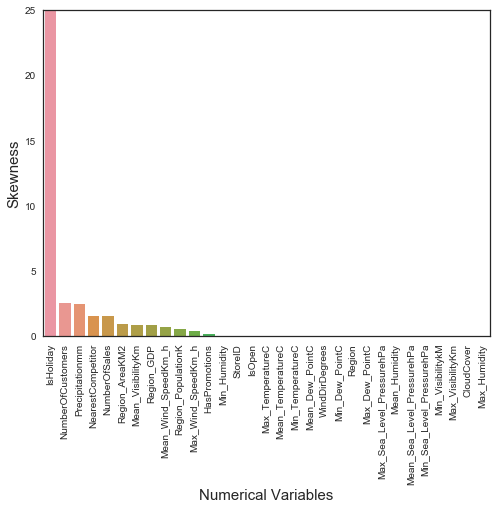

In [19]:
# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold
skewness = skewness.sort_values('Skewness', ascending=[0])
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [20]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday','NumberOfCustomers', "NumberOfSales"])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

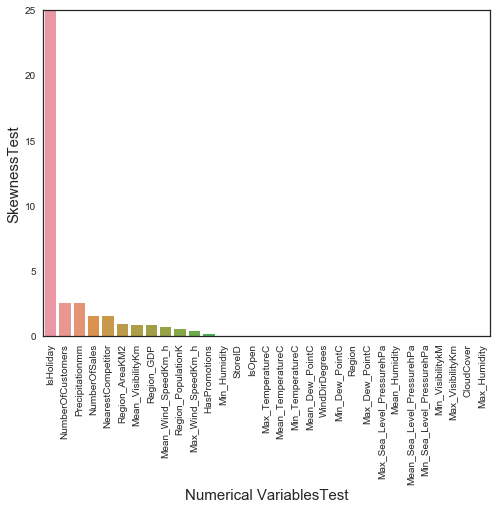

In [21]:
#-----------------------------------TEST----------------------------
# take the numerical features
numeric_featsT = salesTest.dtypes[salesTest.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_featsT = salesTest[numeric_featsT].apply(lambda x: skew(x.dropna()))

skewnessT = pd.DataFrame({"Variable":skewed_featsT.index, "Skewness":skewed_featsT.data})
# select the variables with a skewness above a certain threshold
skewnessT = skewnessT.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewnessT['Variable'], y=skewnessT['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical VariablesTest', fontsize=15)
plt.ylabel('SkewnessTest', fontsize=15)
plt.title('', fontsize=15)


skewed_featsT = skewed_featsT[skewed_featsT > 0.75]
skewed_featsT = skewed_featsT.drop(['IsHoliday','NumberOfCustomers', "NumberOfSales"])
salesTest[skewed_featsT.index] = np.log1p(salesTest[skewed_featsT.index])

# Correlation Analysis and Feature Selection

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [22]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

#------------------------------------TEST--------------------------------------------
#Dropping of not used attributes
salesTest=salesTest.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])

salesTest["Date"] = salesTest["Date"].apply(toDate)
salesTest["Day_Of_Week"] = salesTest["Date"].astype("datetime64").dt.weekday_name

salesTest["Month"] = salesTest["Date"].astype("datetime64").dt.month

#testColumns=salesTest.columns

Drop of the row where IsOpen==0

In [23]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])

### Convert Date to weekday label

In [24]:
sales["Date"] = sales["Date"].apply(toDate)
sales["Day_Of_Week"] = sales["Date"].astype("datetime64").dt.weekday_name

### Convert Date to month label

In [25]:
sales["Month"] = sales["Date"].astype("datetime64").dt.month

### Adding info about avgsales per month ecc.

In [26]:
avgSalesForStoreIDForMonth = sales 
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].mean() 
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "AvgSalesForMonth"})

varSalesForStoreIDForMonth = sales 
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].var() 
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "VarSalesForMonth"})

avgCustomersForStoreIDForMonth = sales 
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].mean() 
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "AvgCustomersForMonth"})

varCustomersorStoreIDForMonth = sales 
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].var() 
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "VarCustomersForMonth"})

sales = sales.merge(avgSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])
sales = sales.merge(avgCustomersForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varCustomersorStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])

In [27]:
#----------------------------TEST-------------------

salesTest = salesTest.merge(avgSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
salesTest = salesTest.merge(varSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])
salesTest = salesTest.merge(avgCustomersForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
salesTest = salesTest.merge(varCustomersorStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])


#one hot encoding
salesTest = pd.get_dummies(salesTest, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week","Month"])
salesTest=salesTest.drop(columns=["Date"])

In [28]:
#NB: there are the rows with IsOpen==0 !

#salesTest=salesTest[salesTest['IsOpen']==1]
#salesTest=salesTest.drop(columns=['IsOpen'])

#https://stackoverflow.com/questions/29459461/pandas-dataframe-to-excel-sheet/29461151?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

#SAVING THE TEST excel
#salesTest.to_excel('TestPreprocessed.xlsx')

#SAVING THE TEST CSV
salesTest.to_csv('TestPreprocessed.csv', sep=',')

In [30]:
sales.head(5)

,StoreID,Date,IsHoliday,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,...,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Day_Of_Week,Month,AvgSalesForMonth,VarSalesForMonth,AvgCustomersForMonth,VarCustomersForMonth
0,1000,2016-03-01,0,0,Hyper Market,General,5.78996,7,495,5676,...,1.0,6.0,0.0,23,Tuesday,3,7509.617021,2.592602e+06,609.212766,7771.997225
1,1000,2016-03-02,0,0,Hyper Market,General,5.78996,7,608,8111,...,1.0,10.0,0.0,56,Wednesday,3,7509.617021,2.592602e+06,609.212766,7771.997225
2,1000,2016-03-04,0,0,Hyper Market,General,5.78996,7,665,8300,...,2.0,8.0,0.0,22,Friday,3,7509.617021,2.592602e+06,609.212766,7771.997225
3,1000,2016-03-05,0,0,Hyper Market,General,5.78996,7,630,7154,...,-1.0,10.0,0.0,108,Saturday,3,7509.617021,2.592602e+06,609.212766,7771.997225
4,1000,2016-03-10,0,1,Hyper Market,General,5.78996,7,617,7823,...,6.0,7.0,0.0,54,Thursday,3,7509.617021,2.592602e+06,609.212766,7771.997225


# Dummify variables

In [31]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week","Month"])

# Train and Test Definition
Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [32]:
start_train = date(2018, 1, 1)
train = sales[sales["Date"] - start_train < timedelta(0)]
test = sales[sales["Date"] - start_train > timedelta(days=1)]
train = train.drop(columns=["Date"])
test = test.drop(columns=["Date"])

Clusterization of regions which are similar or with too few samples to be fitted on their own.
Used t-sne to visualize clusters

In [33]:
Region_labels = [['Region_0', 'Region_1', 'Region_4','Region_5','Region_7', 'Region_8', 'Region_10' ], ['Region_2'], ['Region_3'], ['Region_6', 'Region_9']]

In [34]:
model = None
errors = []
for cluster in Region_labels:
    print("Cluster : " + str(cluster))
    model, errs = Fit(cluster,train,test, model)
    errors+=errs
from functools import reduce
print("Mean Error : ",reduce(lambda x, y: x+y, errors, 0)/len(errors))

Cluster : ['Region_0', 'Region_1', 'Region_4', 'Region_5', 'Region_7', 'Region_8', 'Region_10']
Region 0 :  0.04185022674325638
Region 1 :  0.04175464185527815
Region 4 :  0.0356956215566095
Region 5 :  0.04694196461736769
Region 7 :  0.06183371149384587
Region 8 :  0.047953698451641
Region 10 :  0.035144478918220555
Cluster : ['Region_2']
Region 2 :  0.059682029005135626
Cluster : ['Region_3']
Region 3 :  0.036285625573070836
Cluster : ['Region_6', 'Region_9']
Region 6 :  0.04543887138951645
Region 9 :  0.05106523980128818
Mean Error :  0.045786009945930024
